In [405]:
import os 
import glob
import pandas as pd

import cv2
import numpy as np
#Img Augment

#import imgaug as ia
#import imgaug.augmenters as iaa
#from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from sklearn.model_selection import train_test_split

import torch

import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

from torchsummary import summary

from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as T
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches


from dataload import xml_to_csv,PetData,Sub_region_train,Sub_region

from tqdm import tqdm


In [2]:
##Loading data
#root_path="D:/Dataset/Pet_Data/"
#root_path="D:/Dataset/Pet_Data/"
root_path="D:/Dataset/Oxford"

img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")

seed=0
df=xml_to_csv(annots,img_path)
df.head()

## Make Balanced Dataset (To save time, but don't do this in real research!!)
g = df.groupby('target')
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(),random_state=seed).reset_index(drop=True),))
train, test = train_test_split(balanced_df, test_size=0.2,random_state=seed)

BATCH_SIZE = 1
train_ds = PetData(train, train=True)
valid_ds= PetData(test, train=True)
def collate_fn(batch):
    return zip(*batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=False)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

In [3]:
from collections import Counter
print(Counter(train.target))
from collections import Counter
print(Counter(test.target))

Counter({1: 958, 0: 942})
Counter({0: 246, 1: 230})


In [4]:
import torch.optim as optim
#Loading Pretrained Network
model = models.alexnet(pretrained=True)
model.classifier[6]=nn.Linear(4096,3)
model.load_state_dict(torch.load("models/epoch_46"))

<All keys matched successfully>

# Training SVM

## Extracting Ground Truth Samples for Each Class


In [5]:
#for class
device="cuda"
def get_gt_ft(tgt_class,model,dataset,device):
    cnn_transforms=nn.Upsample((224,224))
    model.eval()
    model.to(device)
    gt_fts=[]
    for i,(img,bboxes) in  tqdm(enumerate(dataset)):
        for (x1,y1,x2,y2,label) in bboxes:
            if label==tgt_class:
                cropped_img=(img[:,int(y1):int(y2),int(x1):int(x2)])
                cropped_img=cnn_transforms(cropped_img.unsqueeze(0))
                cropped_img=cropped_img.to(device)
                gt_ft=model.classifier[0:-2](torch.flatten((model.avgpool(model.features(cropped_img))),1))
                gt_fts.append(gt_ft.cpu())
                break
            else:
                continue
    gt_fts=torch.stack(gt_fts)
    return gt_fts

In [6]:
#gt_ft_cats=get_gt_ft(0,model_ft,train_ds,"cuda")
#torch.save(gt_ft_cats,"gf_cats.pt")

#gt_ft_dogs=get_gt_ft(1,model_ft,train_ds,"cuda")
#torch.save(gt_ft_dogs,"gf_dogs.pt")

## Negative Sampling

In [7]:
seed=0
valid1, valid2 = train_test_split(valid_ds, test_size=0.5,random_state=seed)
BATCH_SIZE = 1


In [8]:
len(valid1)

238

In [9]:
from metrics import iou
def neg_sample(proposed_regions,bboxes):
    ''' 
    if iou below 0.3 it is considered as negative sample for training SVM
    '''
    
    iou_threshold=0.3
    for region in proposed_regions:
        max_iou=0
        region['labels']=-1
        region_tensor=torch.tensor((region['rect'][0],region['rect'][1],region['rect'][0]+region['rect'][2],region['rect'][1]+region['rect'][3]))
        for bbox in bboxes:
            box_tensor=torch.tensor((bbox[0],bbox[1],bbox[2],bbox[3]))
            cur_iou=iou.torch_getIOU(region_tensor,box_tensor)
            if max_iou<cur_iou:
                max_iou=cur_iou
        region['iou']=max_iou
    regions_df=pd.DataFrame.from_dict(proposed_regions)
    regions_df=regions_df[regions_df['iou']<0.3]
    return regions_df

In [11]:

from utills import ssearch,misc
from utills.misc import create_label,balance_df
'''
device='cuda'

model.to(device)
model.eval()

x_ft=[]
y_label=[]    


for img_batch_idx,(img_tuple,bbox) in tqdm(enumerate(valid1)):
    acc_regions=None
    avg_tloss_pimage=0

    img_lbl, regions = ssearch.selective_search(img_tuple.numpy().transpose(1,2,0), scale=100, sigma=0.8, min_size=20)

    regions=neg_sample(regions,bbox)  #Consider IOU<0.3 as negative sapmle
    #Create Dataset of proposed regions
    region_ds=Sub_region(regions,img_tuple,pil=False)
    region_dl=DataLoader(region_ds,batch_size=32)
    with torch.no_grad():
        for batch_idx,(img_tuple,label) in enumerate(region_dl):
            img_tuple=img_tuple.to(device)
            ft_vec=model.classifier[0:-2](torch.flatten((model.avgpool(model.features(img_tuple))),1))
            output=model.classifier[-2:](ft_vec.clone())
            outmax=torch.max(output.data,1).indices.cpu()
            b = outmax != 0
            indices = b.nonzero()
            
            if (len(indices) !=0):                             #Cache False Positive as Hard Negative Sample
                sampled_fn=img_tuple[indices.reshape(-1)]
                out=ft_vec[indices.reshape(-1)].cpu().numpy()
                outmax=outmax[indices.reshape(-1)].numpy()
                x_ft.append(out)
                y_label.append(outmax)
    

x_ft=np.concatenate(x_ft)
y_label=np.concatenate(y_label)
np.save("hard_negative_cat.npy",x_ft[np.where(y_label ==1)])
np.save("hard_negative_dog.npy",x_ft[np.where(y_label ==2)])
'''
print("")

## Train SVM for each_class

In [189]:
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import time

In [190]:
cat_pos=torch.load("gf_cats.pt").squeeze(1).detach().numpy()
cat_neg=torch.tensor(np.load("hard_negative_1.npy"))

In [191]:
x_cat=np.concatenate([cat_pos,cat_neg])
y_cat=np.concatenate([np.ones(cat_pos.shape[0]),np.zeros(cat_neg.shape[0])])

In [194]:
start=time.time()
x_cat,y_cat = shuffle(x_cat,y_cat, random_state=0)
clf_cat = svm.SVC(kernel='linear',max_iter=1000,probability=True)
clf_cat.fit(x_cat, y_cat)
end=time.time()
print(classification_report(y_cat, clf_cat.predict(x_cat)))


C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1468
         1.0       1.00      1.00      1.00       942

    accuracy                           1.00      2410
   macro avg       1.00      1.00      1.00      2410
weighted avg       1.00      1.00      1.00      2410



In [195]:
print(f"Elapsed Time {end-start}")

Elapsed Time 20.374638080596924


In [196]:
dog_pos=torch.load("gf_dogs.pt").squeeze(1).detach().numpy()
dog_neg=torch.tensor(np.load("hard_negative_2.npy"))

In [197]:
x_dog=np.concatenate([dog_pos,dog_neg])
y_dog=np.concatenate([np.ones(dog_pos.shape[0]),np.zeros(dog_neg.shape[0])])

In [198]:
start=time.time()
x_dog,y_dog = shuffle(x_dog,y_dog, random_state=0)
clf_dog = svm.SVC(kernel='linear',max_iter=1000,probability=True)

clf_dog.fit(x_dog, y_dog)
print(classification_report(y_dog, clf_dog.predict(x_dog)))
end=time.time()
print(f"Elapsed Time {end-start}")

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      3213
         1.0       0.92      0.95      0.93       958

    accuracy                           0.97      4171
   macro avg       0.95      0.96      0.96      4171
weighted avg       0.97      0.97      0.97      4171

Elapsed Time 76.66726350784302


In [199]:
import pickle

filename = 'cat_svm.sv'
pickle.dump(clf_cat, open(filename, 'wb'))
filename = 'dog_svm.sv'
pickle.dump(clf_dog, open(filename, 'wb'))



In [200]:
clf_cat = pickle.load(open("cat_svm.sv", 'rb'))
clf_dog = pickle.load(open("dog_svm.sv", 'rb'))

# Evaluating/Testing Model  (We are nearly there!!)

0it [00:00, ?it/s]No handles with labels found to put in legend.
1it [00:11, 11.22s/it]No handles with labels found to put in legend.
2it [00:16,  9.52s/it]No handles with labels found to put in legend.
3it [00:23,  8.60s/it]No handles with labels found to put in legend.
4it [00:30,  8.11s/it]No handles with labels found to put in legend.
5it [00:35,  7.17s/it]No handles with labels found to put in legend.
6it [00:48,  9.01s/it]No handles with labels found to put in legend.
7it [00:56,  8.63s/it]No handles with labels found to put in legend.
8it [01:04,  8.52s/it]No handles with labels found to put in legend.
9it [01:14,  9.04s/it]No handles with labels found to put in legend.
10it [01:22,  8.53s/it]No handles with labels found to put in legend.
11it [01:30,  8.48s/it]No handles with labels found to put in legend.
12it [01:39,  8.77s/it]No handles with labels found to put in legend.
13it [01:52,  9.78s/it]No handles with labels found to put in legend.
14it [02:01,  9.75s/it]No handles 

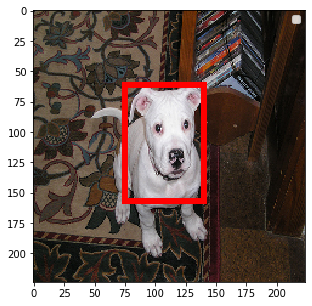

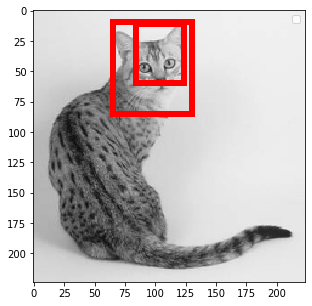

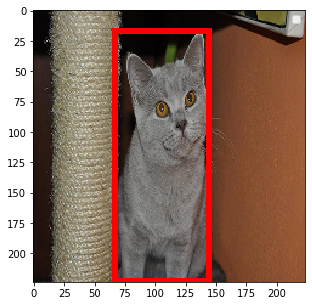

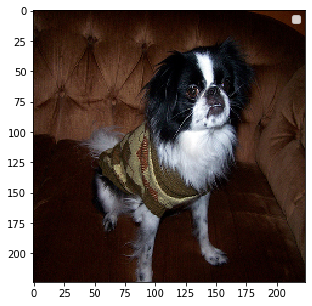

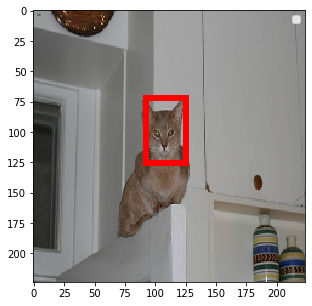

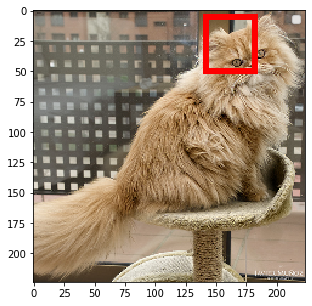

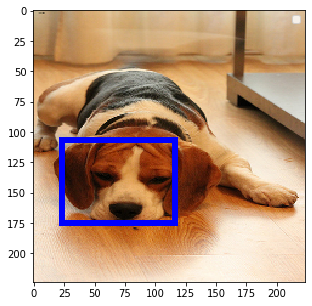

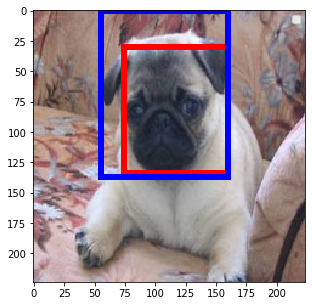

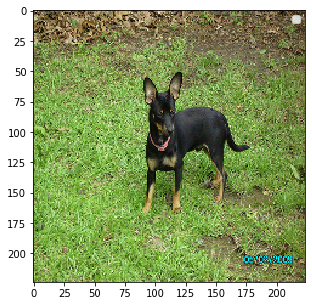

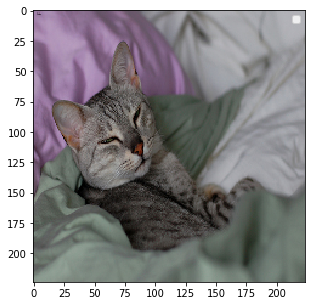

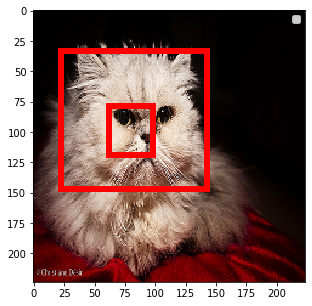

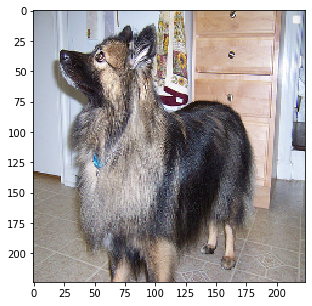

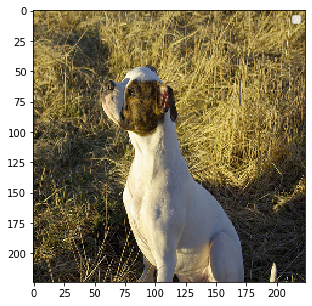

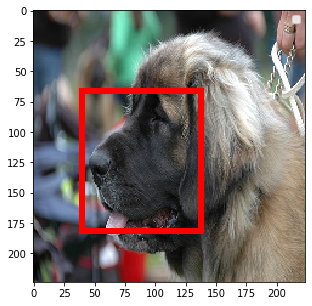

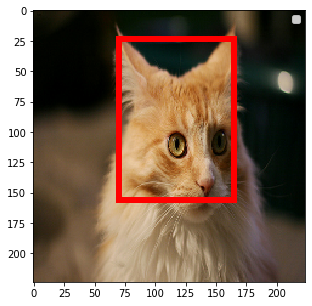

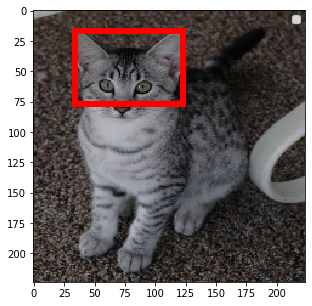

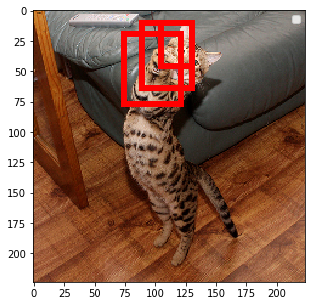

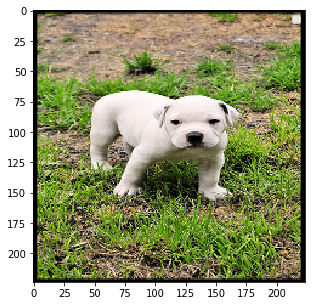

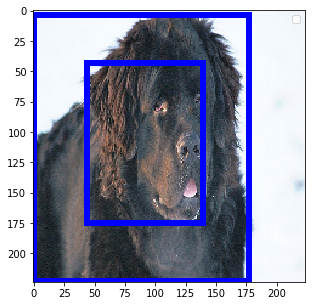

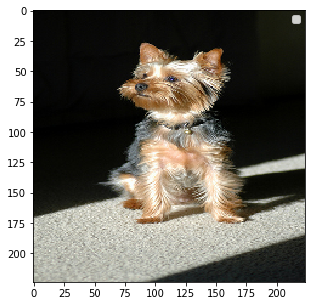

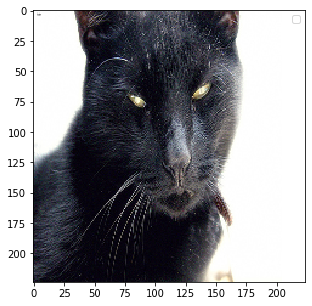

In [413]:
device="cuda"
model.eval()
model.to(device)
COLOR=['red','blue']
LABEL=['cat','dog']
nms_thresh=0.5
for img_batch_idx,(img_tuple,_) in tqdm(enumerate(valid2)):
    acc_regions=None
    avg_tloss_pimage=0

    img_lbl, regions = ssearch.selective_search(img_tuple.numpy().transpose(1,2,0), scale=100, sigma=0.8, min_size=20)
    for region in regions:
        region['labels']=-1
        region_tensor=torch.tensor((region['rect'][0],region['rect'][1],region['rect'][0]+region['rect'][2],region['rect'][1]+region['rect'][3]))
    regions=pd.DataFrame.from_dict(regions)
    
    #Create Dataset of proposed regions
    region_ds=Sub_region(regions,img_tuple,pil=False,return_idx=True)
    region_dl=DataLoader(region_ds,batch_size=32)    
    detected_region_idx=[]
    conf_score=[]
    labels=[]
    with torch.no_grad():
        region_idx=0
        for batch_idx,(region_tuple,_,ds_index) in enumerate(region_dl):
            region_tuple=region_tuple.to(device)
            ft_vec=model.classifier[0:-2](torch.flatten((model.avgpool(model.features(region_tuple))),1))
            prob_cat=clf_cat.predict_proba(ft_vec.cpu().numpy())[:,1]
            prob_dog=clf_dog.predict_proba(ft_vec.cpu().numpy())[:,1]
            pred_cat=clf_cat.predict(ft_vec.cpu().numpy())
            pred_dog=clf_dog.predict(ft_vec.cpu().numpy())
            
            output=[]
            detected=[]
            for idx,(a,b) in enumerate(zip(prob_cat,prob_dog)): 
                max_val=max(a,b)
                label=np.argmax([a,b])
                
                if max_val<0.5:
                    continue
                else:
                    detected_region_idx.append(ds_index[idx].item())        
                    conf_score.append(max_val)
                    labels.append(label)
    det_region=regions.iloc[detected_region_idx].reset_index()
    det_region['conf_score']=conf_score
    det_region['labels']=labels
    
    det_region=det_region.sort_values(["conf_score"], ascending = False)
    
    det_region.drop_duplicates(subset ="rect",
                         keep = False, inplace = True)
    det_region = det_region.drop(det_region[det_region.conf_score < 0.7].index)
    
    
    
    
    final_df=None
    class_df = det_region.groupby('labels')    
    dfs=[class_df.get_group(x) for x in class_df.groups]
    

    for df in dfs:
        idx=0
        while True:
            if idx==len(df):
                break
            anc_box=df.iloc[idx].rect
            flag=[False]*len(df)
            for row_idx_2 in range(idx+1,len(df)):
                if iou.torch_getIOU(cvtbbox(anc_box),cvtbbox(df.iloc[row_idx_2].rect)) > 0.5:
                    flag[row_idx_2]=True
            df=df.drop(df.index[np.where(flag)[0]])

            idx+=1

        if final_df is None:
            final_df=df
        else:
            final_df=final_df.append(df)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(img_tuple.numpy().transpose((1,2,0))*0.5+0.5)
    if final_df is not None:
        for data in final_df.iterrows():
          #  print(data)
            rect=data[1]['rect']
            xy=rect[0],rect[1]
            width=rect[2]
            height=rect[3]

            ax.add_patch(
             patches.Rectangle(
                xy,
                width,
                height,
                edgecolor = COLOR[data[1]["labels"]],
                fill=False,
                linewidth=6,))
    plt.show()
    if img_batch_idx==20:
        break

    

In [395]:
np.where(flag)[0]

array([1], dtype=int64)

In [397]:
d

,index,rect,size,labels,conf_score
6,443,"(75, 61, 65, 96)",3276,0,0.961099


In [264]:
det_region.rect[0]

def cvtbbox(rect):
    '''
    
    input:={x,y,width,height0}
    output={x,y,x+width,y+height}
    '''
    
    return (rect[0],rect[1],rect[0]+rect[2],rect[1]+rect[3])
    
    

In [266]:
flag=[True]*len(det_region)


In [300]:
idxs = np.argsort(scores)

last = len(idxs) - 1


NameError: name 'idxs' is not defined

NameError: name 'idxs' is not defined

In [310]:
idxs

array([], dtype=int64)

In [309]:
idxs=np.argsort(df.conf_score.values)
last=len(idxs)-1
idxs = np.delete(idxs, np.concatenate(([last], np.where(iou_cross > 0.5)[0])))
        

In [375]:
final_df=None
iou_cross=np.zeros((len(det_region),len(det_region)))
class_df = det_region.groupby('labels')    
dfs=[class_df.get_group(x) for x in class_df.groups]


for df in dfs:
    idx=0
    while True:
        if idx==len(df):
            break
        anc_box=df.iloc[idx].rect
        flag=[False]*len(df)
        for row_idx_2 in range(idx+1,len(df)):
            if iou.torch_getIOU(cvtbbox(anc_box),cvtbbox(df.iloc[row_idx_2].rect)) > 0.5:
                flag[row_idx_2]=True
        df=df.drop(df.index[np.where(flag)[0]])

        idx+=1
        
    if final_df is None:
        final_df=df
    else:
        final_df=final_df.append(df)

                


In [376]:
final_df

,index,rect,size,labels,conf_score
6,443,"(75, 61, 65, 96)",3276,0,0.961099
15,782,"(33, 0, 70, 86)",1655,0,0.559218
5,442,"(96, 61, 44, 72)",776,1,0.538370
0,426,"(75, 65, 51, 67)",1256,1,0.518518


[False, False, False]

In [166]:
prob = (Y - Y.min()) / (Y.max() - Y.min())
print('Prob[0]: %.3f' % (1-prob[0]))
print('Prob[1]: %.3f' % (prob[0]))

Prob[0]: nan
Prob[1]: nan


C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [207]:
proba=clf_cat.predict_proba(ft_vec.cpu().numpy())

In [216]:
proba[:,1]

array([1.47684542e-04, 5.01075252e-06, 2.53650911e-05, 4.79932521e-03,
       2.53650911e-05, 4.79932521e-03, 4.79932521e-03, 4.79932521e-03,
       5.01075252e-06, 5.01075252e-06, 3.13608333e-05, 1.00000010e-07,
       1.00000010e-07, 1.00000010e-07, 1.00000010e-07, 1.00000010e-07])

In [206]:
clf_cat.decision_function(ft_vec.cpu().numpy())

array([ -4.00769497,  -5.59681672,  -4.83511319,  -2.37265206,
        -4.83511319,  -2.37265206,  -2.37265206,  -2.37265206,
        -5.59681672,  -5.59681672,  -4.73545603, -11.88137633,
       -13.5403701 , -13.5403701 , -13.5403701 , -13.5403701 ])

In [217]:
proba=clf_dog.predict_proba(ft_vec.cpu().numpy())

In [218]:
proba[:,1]

array([1.09479395e-02, 2.03877238e-02, 6.57500884e-03, 1.14925359e-02,
       6.57500884e-03, 1.14925359e-02, 1.14925359e-02, 1.14925359e-02,
       2.03877238e-02, 2.03877238e-02, 2.55828111e-03, 1.43899765e-04,
       3.86468262e-06, 3.86468262e-06, 3.86468262e-06, 3.86468262e-06])

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1468
         1.0       1.00      1.00      1.00       942

    accuracy                           1.00      2410
   macro avg       1.00      1.00      1.00      2410
weighted avg       1.00      1.00      1.00      2410



In [188]:
clf_cat.predict_proba(ft_vec.cpu().numpy())

array([[9.99773611e-01, 2.26389335e-04],
       [9.99991159e-01, 8.84115010e-06],
       [9.99958163e-01, 4.18372218e-05],
       [9.93634773e-01, 6.36522673e-03],
       [9.99958163e-01, 4.18372218e-05],
       [9.93634773e-01, 6.36522673e-03],
       [9.93634773e-01, 6.36522673e-03],
       [9.93634773e-01, 6.36522673e-03],
       [9.99991159e-01, 8.84115010e-06],
       [9.99991159e-01, 8.84115010e-06],
       [9.99948728e-01, 5.12723529e-05],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07]])

In [128]:
np.maximum(dfc,dfd)

array([ 0.21248113,  0.06849083, -0.35280456, -0.11286225, -0.07383667,
        0.09714172, -0.78051244, -0.55083982,  0.44318874, -0.80631246,
        0.45250598,  1.05494501, -0.71468614,  0.67765884, -0.0759865 ,
        0.7400452 ,  0.88130578,  1.0113231 ,  0.82722229, -1.3941175 ,
       -0.7551146 , -0.13120964,  0.06247758, -0.68962013, -0.19466711,
       -0.58562162, -0.22940431, -0.13365673,  0.05053502, -0.57615244,
       -0.28028913, -0.57200612])

In [130]:
np.argmax([dfc,dfd])

43

In [131]:
[map(max,a,b) for a,b in zip(dfc,dfd)]

TypeError: 'numpy.float64' object is not iterable